In [15]:
from astropy.io import fits
import sys
import pandas as pd
from astropy.table import unique, Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
from numcosmo_py import Ncm, Nc, sky_match
from numcosmo_py.external.pyssc import pyssc as PySSC
from numcosmo_py.helper import npa_to_seq
import timeit
Ncm.cfg_init()

from getdist.mcsamples import  MCSamples
from getdist import plots
import getdist
%matplotlib inline

# Cosmological Model

In [3]:
# Taking some important information about the fiducial cosmological model and survey region
sky_area = 439.790

#cosmological model
cosmo = Nc.HICosmoDEXcdm()
cosmo.omega_x2omega_k()
cosmo.param_set_by_name("Omegak",0.0)
cosmo.param_set_by_name("H0", 71)
cosmo.param_set_by_name("Omegab", 0.0448)
cosmo.param_set_by_name("Omegac", 0.22)  # 0.2603

cosmo.param_set_by_name("w", -1.0)  # -1.0

prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA",  3.05991748699321)
prim.props.n_SA = 0.963
reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)

#matter power spectrum
tf = Nc.TransferFuncEH()

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
psf.prepare(cosmo)
print(cosmo.sigma8(psf))

dist = Nc.Distance.new(2.0)
dist.prepare(cosmo)

0.8000000000000014


# Cluster Mass-Richness and photoz model 

In [4]:
cluster_m = Nc.ClusterMassAscaso(lnRichness_min = 0.0 ,lnRichness_max = 6.0)
cluster_m.param_set_by_name("mup0", 4.11945317984568)
cluster_m.param_set_by_name("mup1", 1.11236863168254)
cluster_m.param_set_by_name("mup2", 0.299464198653602)
cluster_m.param_set_by_name("sigmap0", 0.471246505057074)
cluster_m.param_set_by_name("sigmap1", -0.0591674971985774)
cluster_m.param_set_by_name("sigmap2", -0.109077938873429)
cluster_m.param_set_by_name("cut", 0.0)

cluster_m.param_set_desc("mup0",{ "lower-bound": 3.0,"upper-bound": 5.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 4.11945317984568})
cluster_m.param_set_desc("mup1",{ "lower-bound": 0.0,"upper-bound": 3.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 1.11236863168254})
cluster_m.param_set_desc("mup2",{ "lower-bound": -1.0,"upper-bound": 1.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.299464198653602})
cluster_m.param_set_desc("sigmap0",{ "lower-bound": 0.1,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.471246505057074})
cluster_m.param_set_desc("sigmap1",{ "lower-bound": -0.1,"upper-bound": -0.00001,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": -0.0591674971985774})
cluster_m.param_set_desc("sigmap2",{ "lower-bound": -0.3,"upper-bound": 0.1,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":-0.109077938873429})


cut = np.log(5.0)
cluster_m_truncated = Nc.ClusterMassAscaso(lnRichness_min = cut ,lnRichness_max = 6.0)
cluster_m_truncated.param_set_by_name("mup0", 4.11945317984568)
cluster_m_truncated.param_set_by_name("mup1", 1.11236863168254)
cluster_m_truncated.param_set_by_name("mup2", 0.299464198653602)
cluster_m_truncated.param_set_by_name("sigmap0", 0.471246505057074)
cluster_m_truncated.param_set_by_name("sigmap1", -0.0591674971985774)
cluster_m_truncated.param_set_by_name("sigmap2", -0.109077938873429)
cluster_m_truncated.param_set_by_name("cut", cut)

cluster_m_truncated.param_set_desc("mup0",{ "lower-bound": 3.0,"upper-bound": 5.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 4.11945317984568})
cluster_m_truncated.param_set_desc("mup1",{ "lower-bound": 0.0,"upper-bound": 3.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 1.11236863168254})
cluster_m_truncated.param_set_desc("mup2",{ "lower-bound": -1.0,"upper-bound": 1.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.299464198653602})
cluster_m_truncated.param_set_desc("sigmap0",{ "lower-bound": 0.2,"upper-bound": 2.0,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": 0.471246505057074})
cluster_m_truncated.param_set_desc("sigmap1",{ "lower-bound": -0.1,"upper-bound": -0.00001,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value": -0.0591674971985774})
cluster_m_truncated.param_set_desc("sigmap2",{ "lower-bound": -0.3,"upper-bound": 0.1,"scale": 1.0e-2,"abstol": 1.0e-50,"fit": True,"value":-0.109077938873429})

cluster_z = Nc.ClusterRedshiftNodist(z_min = 0.0 ,z_max = 1.1)

# Cluster abundance model

In [5]:
mulf = Nc.MultiplicityFuncDespali.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.prepare(cosmo)
hbias = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf, hbias)
cad.set_area(sky_area * (np.pi / 180) ** 2)
cad.prepare(cosmo , cluster_z , cluster_m)
print(cad.n(cosmo ,cluster_z , cluster_m))

183710.07160070643


# Data generation

## Fiducial Data

In [6]:
rng = Ncm.RNG.seeded_new(None, 13)
mset = Ncm.MSet.new_array([cluster_m, cosmo, cluster_z])
mset.prepare_fparam_map()

ncdata = Nc.DataClusterNCount.new(cad, "NcClusterRedshiftNodist", "NcClusterMassAscaso")
ncdata.init_from_sampling(mset, sky_area * (np.pi / 180) ** 2  , rng)

lnM_obs_data = np.array([ncdata.get_lnM_obs().get_col(0).get(i) for i in range(ncdata.get_lnM_obs().get_col(0).len())])
lnM_true     = np.array([ncdata.get_lnM_true().get(i) for i in range(ncdata.get_lnM_obs().get_col(0).len())])
z_obs_data    = np.array([ncdata.get_z_obs().get_col(0).get(i) for i in range(ncdata.get_z_obs().get_col(0).len())])
z_true   = np.array([ncdata.get_z_true().get(i) for i in range(ncdata.get_z_obs().get_col(0).len())])

## Truncated data

In [7]:
cut = np.log(5)
data_df = pd.DataFrame({"lnR": lnM_obs_data , "lnM":lnM_true, "z_obs": z_obs_data, "z_true":z_true })

data_truncated = data_df[data_df['lnR'] > cut]
mset_truncated = Ncm.MSet.new_array([cluster_m_truncated, cosmo, cluster_z])
mset_truncated.prepare_fparam_map()

# Fitting fiducial data

## Number counts

In [7]:
# Likelihood
dset = Ncm.Dataset.new()
dset.append_data(ncdata)

lh = Ncm.Likelihood.new(dset)
fit = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)
#fit.run(Ncm.FitRunMsgs.SIMPLE)
#fit.obs_fisher()
#fit.log_covar()
#fit.log_info()

nwalkers = 500

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new(fit, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL)
esmcmc.set_nthreads(2)
esmcmc.set_data_file("mcmc_fiducial_counts.fits")

esmcmc.set_skip_check(True)
esmcmc.start_run()
esmcmc.run(200)
esmcmc.end_run()

esmcmc.mean_covar()
fit.log_covar()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  8
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      2
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensemble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0500.
#   Number of threads: 0002.
#   Using MPI:         no - use MPI enabled but no slaves available.
#----------------------------------------------------------------------------------
# Data used:
#   - Cluster NCount resample unbinned. Generated 184439 from mean 2.3355e+05
#        (full). Mass proxy type `NcClusterMassAscaso', redshift proxy type
#        `NcClusterRedshiftNodist'. Resampled in range [  0.0000,   1.1000]
#        [1.00000000e+13, 1.00000000e+16] and area 439.7900 degrees square.
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Model set:
#---------------------------------------------------

## Self-Calibration

In [8]:
lnM_v = Ncm.Vector.new_array(npa_to_seq(lnM_true))
z_v = Ncm.Vector.new_array(npa_to_seq(z_true))
rich_v = Ncm.Vector.new_array(npa_to_seq(lnM_obs_data))

dmr = Nc.DataClusterMassRich.new()
dmr.set_data(lnM_v, z_v, rich_v)

dset = Ncm.Dataset.new()
dset.append_data(dmr)
lh_sc = Ncm.Likelihood.new(dset)

fit_sc = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh_sc, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)
fit_sc.run(Ncm.FitRunMsgs.SIMPLE)
fit_sc.obs_fisher()
fit_sc.log_covar()
fit_sc.log_info()

nwalkers = 500

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new(fit_sc, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL)
esmcmc.set_nthreads(2)
esmcmc.set_data_file("mcmc_fiducial_self_calibration.fits")

esmcmc.start_run()
esmcmc.run(200)
esmcmc.end_run()

esmcmc.mean_covar()
fit_sc.log_covar()

#----------------------------------------------------------------------------------
# Model fitting. Iterating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiation (central)
....................................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:11.1241500
#  iteration            [000276]
#  function evaluations [000278]
#  gradient evaluations [000000]
#  degrees of freedom   [184433]
#  m2lnL     =    -91965.3683952966 (    -91965.368 )
#  Fit parameters:
#     4.11401688896484       1.11036122366465       0.291863820814787      0.474785472904667     -0.0582937333483446    -0.121711517812607     
# Computing Hessian matrix using numerical differentiation.
#  - relative tolerance: 1.00e-05
................................................................................................................................................................................

# Fitting truncated data

## Number counts

In [9]:
lnM_v = Ncm.Vector.new_array(npa_to_seq(data_truncated['lnM']))
z_v = Ncm.Vector.new_array(npa_to_seq(data_truncated['z_true']))
rich_v = Ncm.Vector.new_array(npa_to_seq(data_truncated['lnR']))


ncdata_truncated = Nc.DataClusterNCount.new(cad, "NcClusterRedshiftNodist", "NcClusterMassAscaso")

ncdata_truncated.set_init(True)
ncdata_truncated.prepare(mset_truncated)
ncdata_truncated.set_lnM_true(lnM_v)
ncdata_truncated.set_z_true(z_v)
ncdata_truncated.set_lnM_obs(Ncm.Matrix.new_array(npa_to_seq(data_truncated['lnR']),1))
ncdata_truncated.set_z_obs(Ncm.Matrix.new_array(npa_to_seq(data_truncated['z_true']),1))


# Likelihood
dset_truncated = Ncm.Dataset.new()
dset_truncated.append_data(ncdata_truncated)

lh_truncated = Ncm.Likelihood.new(dset_truncated)
fit_truncated = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh_truncated, mset_truncated, Ncm.FitGradType.NUMDIFF_CENTRAL
)
#fit_truncated.run(Ncm.FitRunMsgs.SIMPLE)
#fit_truncated.obs_fisher()
#fit_truncated.log_covar()
#fit_truncated.log_info()

nwalkers = 500

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset_truncated)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new(fit_truncated, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL)
esmcmc.set_nthreads(2)
esmcmc.set_data_file("mcmc_truncated_counts.fits")

esmcmc.set_skip_check(True)
esmcmc.start_run()
esmcmc.run(200)
esmcmc.end_run()

esmcmc.mean_covar()
fit_truncated.log_covar()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  8
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      2
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Starting Ensemble Sampler Markov Chain Monte Carlo.
#   Number of walkers: 0500.
#   Number of threads: 0002.
#   Using MPI:         no - use MPI enabled but no slaves available.
#----------------------------------------------------------------------------------
# Data used:
#   - Cluster abundance unbinned
#----------------------------------------------------------------------------------
# NcmFitESMCMC: Model set:
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  71                  [FIXED]
#   -     Omegac[01]:  0.22      

## Self Calibration

In [ ]:
lnM_v = Ncm.Vector.new_array(npa_to_seq(data_truncated['lnM']))
z_v = Ncm.Vector.new_array(npa_to_seq(data_truncated['z_true']))
rich_v = Ncm.Vector.new_array(npa_to_seq(data_truncated['lnR']))

dmr_truncated = Nc.DataClusterMassRich.new()
dmr_truncated.set_data(lnM_v, z_v, rich_v)

dset_truncated = Ncm.Dataset.new()
dset_truncated.append_data(dmr_truncated)
lh_truncated_sc = Ncm.Likelihood.new(dset_truncated)

fit_truncated_sc = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh_truncated_sc, mset_truncated, Ncm.FitGradType.NUMDIFF_CENTRAL
)
fit_truncated_sc.run(Ncm.FitRunMsgs.SIMPLE)
fit_truncated_sc.obs_fisher()
fit_truncated_sc.log_covar()
fit_truncated_sc.log_info()

nwalkers = 500

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset_truncated)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new(fit_truncated_sc, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL)
esmcmc.set_nthreads(2)
esmcmc.set_data_file("mcmc_truncated_self_calibration.fits")

esmcmc.start_run()
esmcmc.run(200)
esmcmc.end_run()

esmcmc.mean_covar()
fit_truncated_sc.log_covar()

# Corner plot Number Counts

Removed no burn in
Removed no burn in


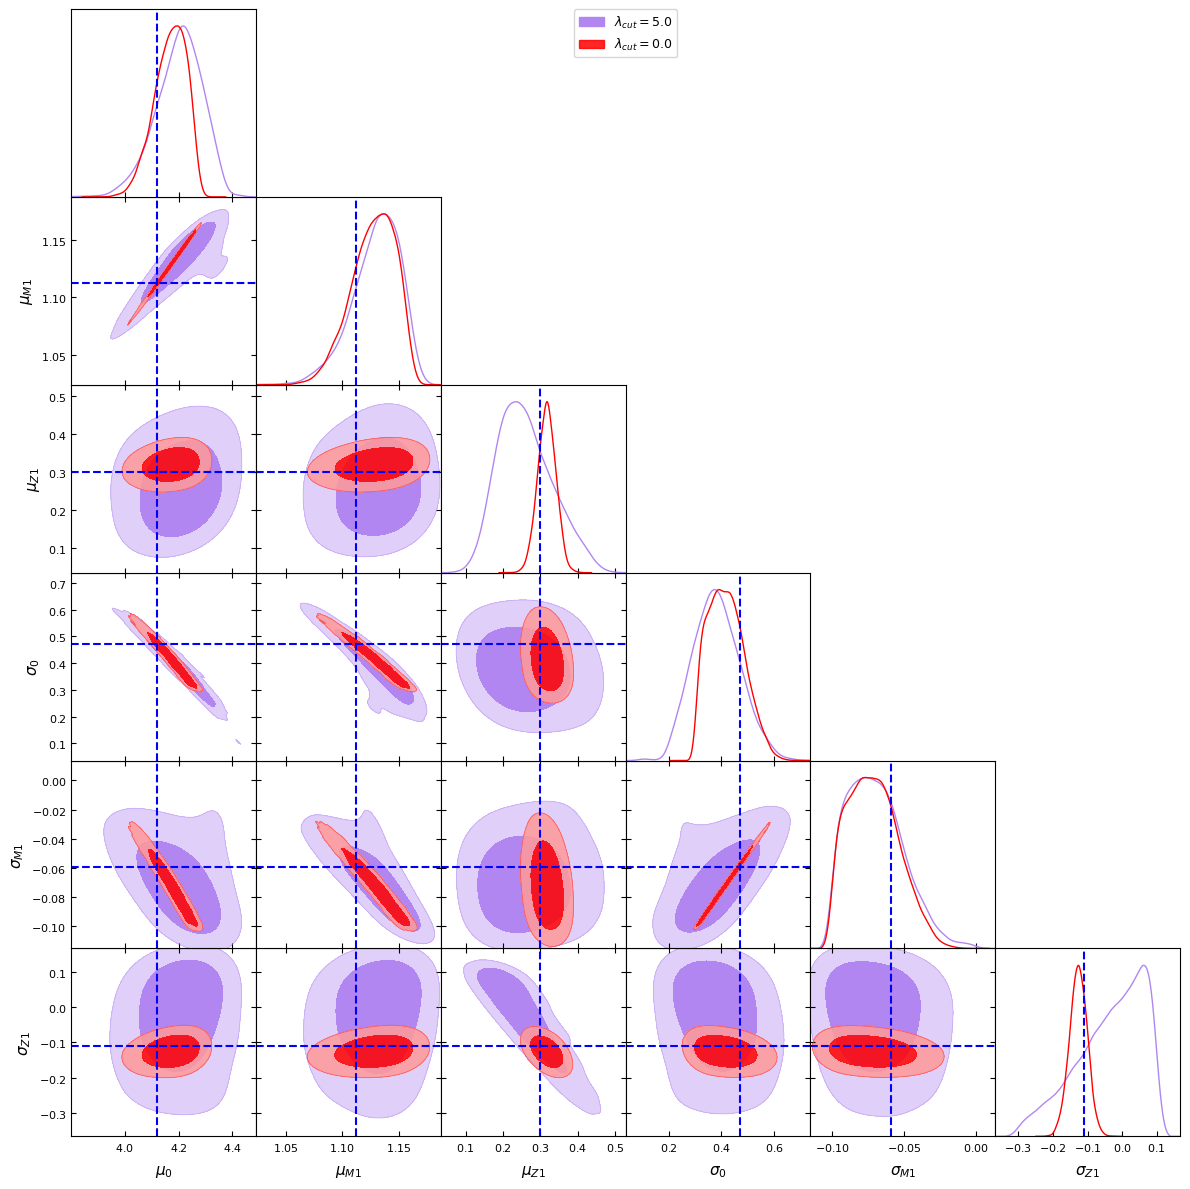

In [16]:
data_fit_fiducial_counts = (
    pd.DataFrame(fits.open("mcmc_fiducial_counts.fits")[1].data).iloc[:, 1:7].T
)

data_fit_truncated_counts = (
    pd.DataFrame(fits.open("mcmc_truncated_counts.fits")[1].data).iloc[:, 1:7].T
)

data_fit_void_fiducial_counts = np.array(data_fit_fiducial_counts)
data_fit_void_truncated_counts = np.array(data_fit_truncated_counts)
data_fit = []
for item in data_fit_void_fiducial_counts:
    arr = np.array(item)
    data_fit.append(np.asarray(arr.tolist()))

data_fit_2 = []
for item in data_fit_void_truncated_counts:
    arr = np.array(item)
    data_fit_2.append(np.asarray(arr.tolist()))

names = ['1','2','3','4','5','6',]
labels = [r"\mu_0", r"\mu_{M1}" ,r"\mu_{Z1}",r"\sigma_0", r"\sigma_{M1}", r"\sigma_{Z1}"]

settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples_fiducial  = MCSamples(samples=data_fit, names=names, labels=labels, settings=settings)
samples_truncated = MCSamples(samples=data_fit_2, names=names, labels=labels, settings=settings)

bf = [4.11945317984568 , 1.11236863168254 , 0.299464198653602 ,  0.471246505057074, -0.0591674971985774,  -0.109077938873429]


samples_fiducial.removeBurn(0.5)
samples_truncated.removeBurn(0.5)

# Triangle plot
g2 = plots.get_subplot_plotter()
g2.triangle_plot(
    [samples_truncated,samples_fiducial],
    filled=True,
    contour_ls="-",
    contour_lws=1,
    fine_bins=1,
    colors=["#b186f1" , "red"],
    fontsize=70,
    line_args=[{"lw": 1.2, "ls": "-", "color": "#b186f1"}],
    legend_labels=[
        r"$\lambda_{cut} =5.0$",r"$\lambda_{cut} =0.0$"
    ],
)


for i, param1 in enumerate(names):
    for j, param2 in enumerate(names):
        if i == j:
            g2.subplots[i, j].axvline(
                bf[i], color="blue" ,linestyle="--", label="Best Fit"
            )
        elif i > j:
            g2.subplots[i, j].axvline(bf[j], color="blue", linestyle="--")
            g2.subplots[i, j].axhline(bf[i], color="blue", linestyle="--")


plt.savefig("mcmc_corner_plot_counts.png")
plt.show()

# Corner plot Self Calibration

Removed no burn in
Removed no burn in


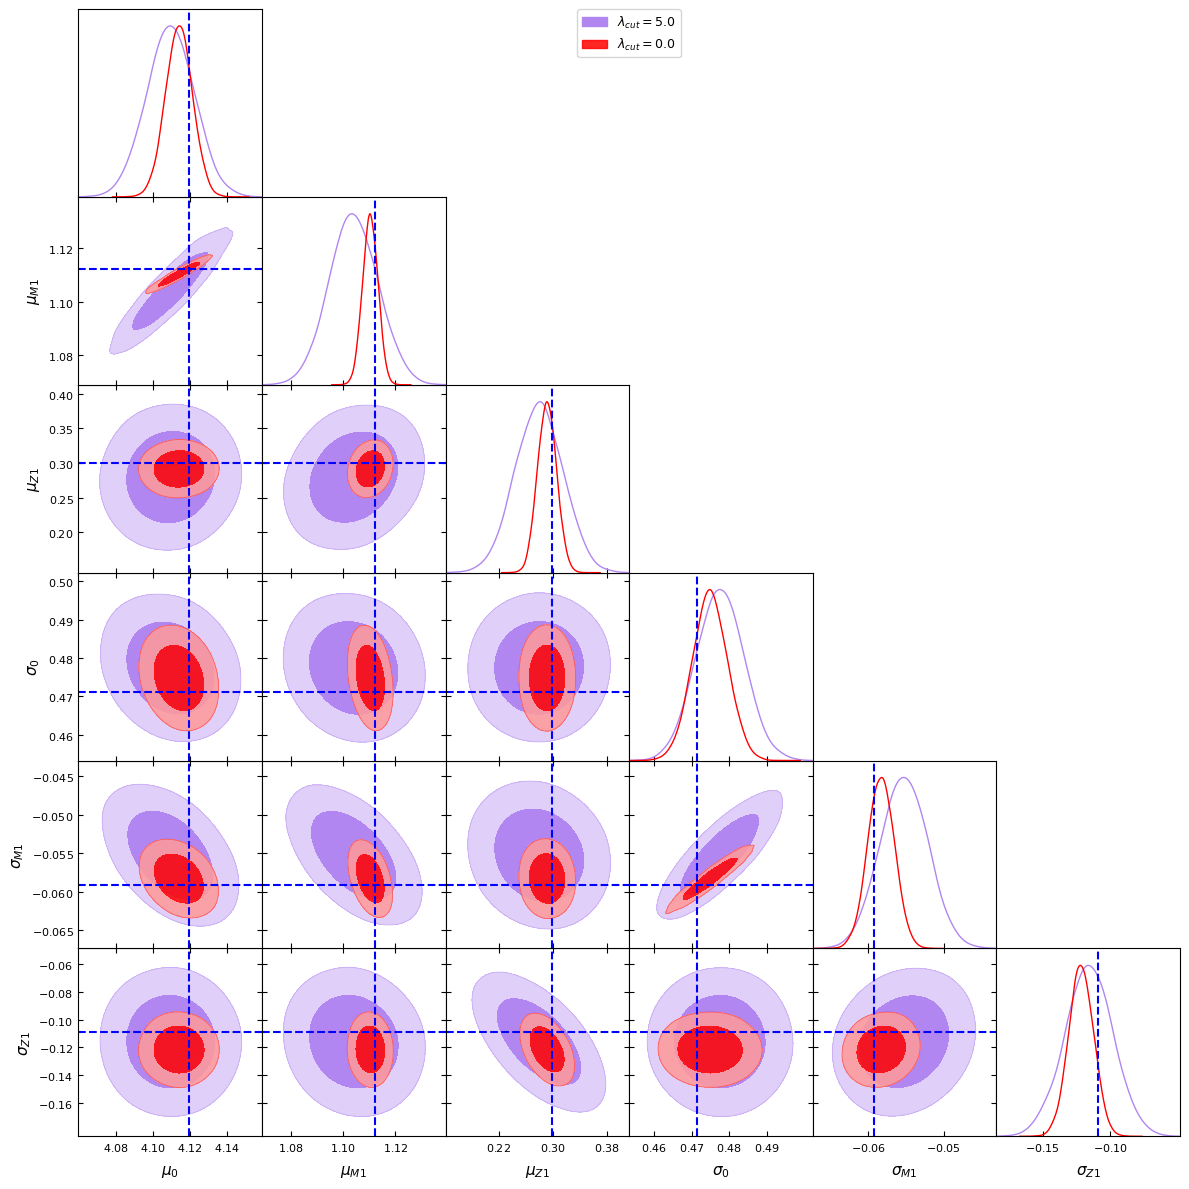

In [17]:
data_fit_fiducial_sc = (
    pd.DataFrame(fits.open("mcmc_fiducial_self_calibration.fits")[1].data).iloc[:, 1:7].T
)

data_fit_truncated_sc = (
    pd.DataFrame(fits.open("mcmc_truncated_self_calibration.fits")[1].data).iloc[:, 1:7].T
)

data_fit_void_fiducial_sc = np.array(data_fit_fiducial_sc)
data_fit_void_truncated_sc = np.array(data_fit_truncated_sc)
data_fit = []
for item in data_fit_void_fiducial_sc:
    arr = np.array(item)
    data_fit.append(np.asarray(arr.tolist()))

data_fit_2 = []
for item in data_fit_void_truncated_sc:
    arr = np.array(item)
    data_fit_2.append(np.asarray(arr.tolist()))

names = ['1','2','3','4','5','6',]
labels = [r"\mu_0", r"\mu_{M1}" ,r"\mu_{Z1}",r"\sigma_0", r"\sigma_{M1}", r"\sigma_{Z1}"]

settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 3,
    "smooth_scale_1D": 3,
    "boundary_correction_order": 0,
}
samples_fiducial  = MCSamples(samples=data_fit, names=names, labels=labels, settings=settings)
samples_truncated = MCSamples(samples=data_fit_2, names=names, labels=labels, settings=settings)

bf = [4.11945317984568 , 1.11236863168254 , 0.299464198653602 ,  0.471246505057074, -0.0591674971985774,  -0.109077938873429]


samples_fiducial.removeBurn(0.3)
samples_truncated.removeBurn(0.3)

# Triangle plot
g2 = plots.get_subplot_plotter()
g2.triangle_plot(
    [samples_truncated,samples_fiducial],
    filled=True,
    contour_ls="-",
    contour_lws=1,
    fine_bins=1,
    colors=["#b186f1" , "red"],
    fontsize=70,
    line_args=[{"lw": 1.2, "ls": "-", "color": "#b186f1"}],
    legend_labels=[
        r"$\lambda_{cut} =5.0$",r"$\lambda_{cut} =0.0$"
    ],
)


for i, param1 in enumerate(names):
    for j, param2 in enumerate(names):
        if i == j:
            g2.subplots[i, j].axvline(
                bf[i], color="blue" ,linestyle="--", label="Best Fit"
            )
        elif i > j:
            g2.subplots[i, j].axvline(bf[j], color="blue", linestyle="--")
            g2.subplots[i, j].axhline(bf[i], color="blue", linestyle="--")


plt.savefig("mcmc_corner_plot_sc.png")
plt.show()